## import libraries

In [9]:
import os
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random as rn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , roc_curve , auc
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten, Dense, Activation,BatchNormalization
from tensorflow.keras.applications import inception_v3 
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D,MaxPooling2D, Dropout,Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import vgg16

## Read data and make data pickle

In [10]:
data_dir = "E:\GSSOC'22\Breast-Cancer-Predictor-master\BCP_Image_Dataset"

In [11]:
categories = ["benign","malignant"]

In [12]:
data = []
def make_data():
    for category in categories:
        path = os.path.join(data_dir,category)
        label = categories.index(category)
        print(category + "--" + str(label))
        for img_name in os.listdir(path):
            img_path = os.path.join(path,img_name)
            image = cv2.imread(img_path)
            try:
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,(224,224))
                image = np.array(image,dtype=np.float32)
                data.append([image,label])
            except Exception as e:
                pass
    print(len(data))
    pik = open("pikle files\data.pickle","wb")
    pickle.dump(data,pik)
    pik.close()
make_data()

benign--0
malignant--1
459


In [13]:
def load_data():
    pick  = open("pikle files\data.pickle","rb")
    data = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(data)
    feature = []
    labels = []
    
    for img , label in data:
        feature.append(img)
        labels.append(label)
    
    feature = np.array(feature, dtype=np.float32)
    labels = np.array(labels)

    feature = feature/255.0

    return [feature, labels]
    

In [14]:
feature,labels = load_data()

In [15]:
print(feature.shape)

(459, 224, 224, 3)


## Data Generation 

In [16]:
x_train,x_test,y_train,y_test = train_test_split(feature,labels,test_size = 0.25,random_state = 42)

In [17]:
datagen_train = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen_train.fit(x_train)

datagen_test = ImageDataGenerator(
        rescale = 1./255
)

datagen_test.fit(x_test)

In [18]:
tf.random.set_seed(
  np.random.seed(42)
)

## Confusion Matrix 

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (5,5), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Prediction')

## resnet50

In [20]:
def create_model1():
    base_model=resnet50.ResNet50(include_top=False, input_shape=(224,224,3))

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1, activation='sigmoid')(x)
    model1=Model(inputs=base_model.input, outputs=x)


    for layer in base_model.layers:
        layer.trainable=False
    
    return model1

In [21]:
batch_size=9
epochs=10

from keras.callbacks import ReduceLROnPlateau
red_lr1= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [22]:
model1 = create_model1()

model1.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [23]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [24]:
History1 = model1.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
39/39 [==============================] - 46s 1s/step - loss: 0.6922 - accuracy: 0.5320 - val_loss: 0.6876 - val_accuracy: 0.6261
Epoch 2/10
39/39 [==============================] - 40s 1s/step - loss: 0.6867 - accuracy: 0.5552 - val_loss: 0.6756 - val_accuracy: 0.5826
Epoch 3/10
39/39 [==============================] - 43s 1s/step - loss: 0.6826 - accuracy: 0.5581 - val_loss: 0.6896 - val_accuracy: 0.4435
Epoch 4/10
39/39 [==============================] - 39s 1s/step - loss: 0.6723 - accuracy: 0.5872 - val_loss: 0.6840 - val_accuracy: 0.5826
Epoch 5/10
39/39 [==============================] - 39s 1s/step - loss: 0.6631 - accuracy: 0.5930 - val_loss: 0.6551 - val_accuracy: 0.5826
Epoch 6/10
39/39 [==============================] - 38s 980ms/step - loss: 0.6630 - accuracy: 0.5872 - val_loss: 0.7040 - val_accuracy: 0.4174
Epoch 7/10
39/39 [==============================] - 39s 995ms/step - loss: 0.6607 - accuracy: 0.6105 - val_loss: 0.6602 - val_accuracy: 0.7217
Epoch 8/10
39/

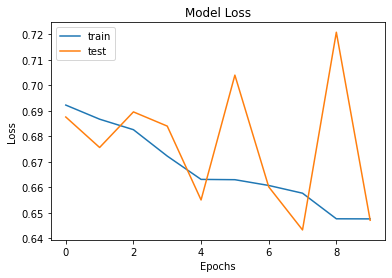

In [25]:
plt.plot(History1.history['loss'])
plt.plot(History1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

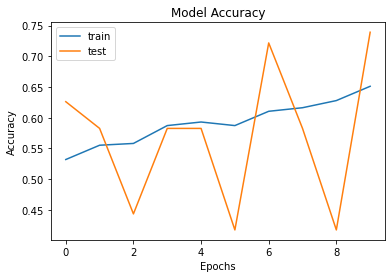

In [26]:
plt.plot(History1.history['accuracy'])
plt.plot(History1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [27]:
model1.save("pikle files/BCDRESNET50.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [28]:
_, acc1 = model1.evaluate(x_test, y_test)
print("Accuracy = ", (acc1 * 100.0), "%")

4/4 [==============================] - 9s 2s/step - loss: 0.6471 - accuracy: 0.7391
Accuracy =  73.9130437374115 %


In [29]:
pred1=model1.predict(x_test)
pred_digits1=np.round(abs(pred1)).astype(int)
print(pred_digits1)

[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]]


In [30]:
print(classification_report(y_test,pred_digits1))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76        67
           1       0.66      0.79      0.72        48

    accuracy                           0.74       115
   macro avg       0.74      0.75      0.74       115
weighted avg       0.75      0.74      0.74       115



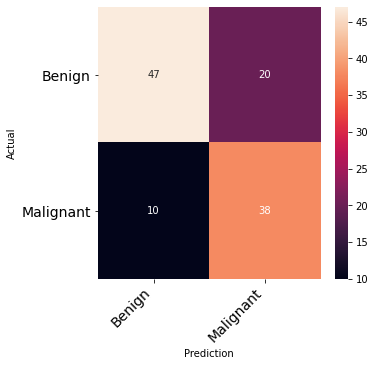

In [31]:
cm = confusion_matrix(y_test,pred_digits1)
print_confusion_matrix(cm,["Benign","Malignant"])

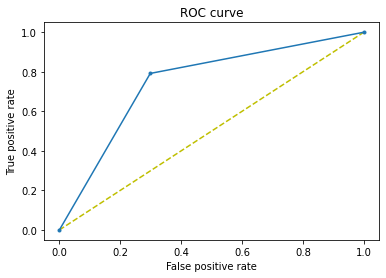

In [32]:
roc1 = pred_digits1.ravel()
fpr, tpr, thresholds = roc_curve(y_test, roc1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [33]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1
Name: thresholds, dtype: int32


In [34]:
auc_value1 = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value1)

Area under curve, AUC =  0.7465796019900497


## VGG16

In [35]:
def create_model2():
    base_model=vgg16.VGG16(include_top=False, input_shape=(224,224,3))

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1, activation='sigmoid')(x)
    model2=Model(inputs=base_model.input, outputs=x)


    for layer in base_model.layers:
        layer.trainable=False
    
    return model2

In [36]:
batch_size=9
epochs=10

from keras.callbacks import ReduceLROnPlateau
red_lr2= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [37]:
model2 = create_model2()

model2.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [38]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [39]:
History2 = model2.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
39/39 [==============================] - 107s 3s/step - loss: 0.6982 - accuracy: 0.5552 - val_loss: 0.6630 - val_accuracy: 0.5826
Epoch 2/10
39/39 [==============================] - 102s 3s/step - loss: 0.6739 - accuracy: 0.5581 - val_loss: 0.6501 - val_accuracy: 0.5826
Epoch 3/10
39/39 [==============================] - 102s 3s/step - loss: 0.6591 - accuracy: 0.5610 - val_loss: 0.6367 - val_accuracy: 0.5826
Epoch 4/10
39/39 [==============================] - 103s 3s/step - loss: 0.6433 - accuracy: 0.6163 - val_loss: 0.6247 - val_accuracy: 0.5913
Epoch 5/10
39/39 [==============================] - 104s 3s/step - loss: 0.6291 - accuracy: 0.6337 - val_loss: 0.6119 - val_accuracy: 0.6174
Epoch 6/10
39/39 [==============================] - 97s 3s/step - loss: 0.6140 - accuracy: 0.7006 - val_loss: 0.6017 - val_accuracy: 0.7217
Epoch 7/10
39/39 [==============================] - 104s 3s/step - loss: 0.6016 - accuracy: 0.7529 - val_loss: 0.5937 - val_accuracy: 0.7913
Epoch 8/10
39/

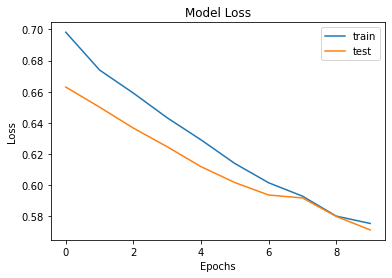

In [40]:
plt.plot(History2.history['loss'])
plt.plot(History2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

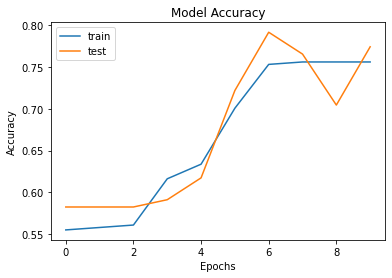

In [41]:
plt.plot(History2.history['accuracy'])
plt.plot(History2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [42]:
pred2=model2.predict(x_test)
pred_digits2=np.round(abs(pred2)).astype(int)
print(pred_digits2)

[[1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [43]:
model2.save("pikle files/BCDVGG16.h5")

In [44]:
_, acc2 = model2.evaluate(x_test, y_test)
print("Accuracy = ", (acc2 * 100.0), "%")

4/4 [==============================] - 26s 6s/step - loss: 0.5714 - accuracy: 0.7739
Accuracy =  77.3913025856018 %


In [45]:
print(classification_report(y_test,pred_digits2))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82        67
           1       0.81      0.60      0.69        48

    accuracy                           0.77       115
   macro avg       0.78      0.75      0.76       115
weighted avg       0.78      0.77      0.77       115



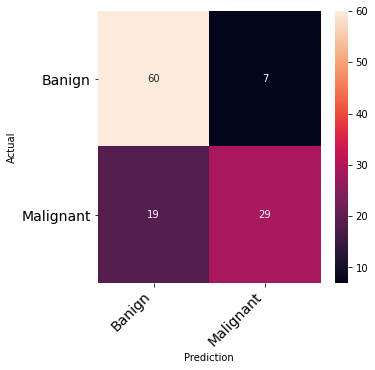

In [46]:
cm = confusion_matrix(y_test,pred_digits2)
print_confusion_matrix(cm,["Banign","Malignant"])

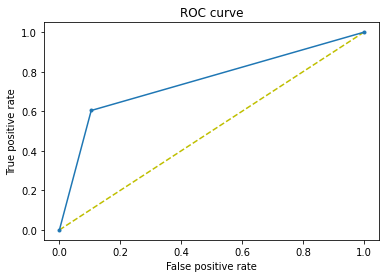

In [47]:
roc2 = pred_digits2.ravel()
fpr, tpr, thresholds = roc_curve(y_test, roc2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [48]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1
Name: thresholds, dtype: int32


In [49]:
auc_value2 = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value2)

Area under curve, AUC =  0.7498445273631841


## inception_v3 

In [50]:
def create_model3():
    base_model=inception_v3.InceptionV3(include_top=False, input_shape=(224,224,3))

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1, activation='sigmoid')(x)  #softmax
    model3=Model(inputs=base_model.input, outputs=x)


    for layer in base_model.layers:
        layer.trainable=False
    
    return model3

In [51]:
batch_size=9
epochs=10

from keras.callbacks import ReduceLROnPlateau
red_lr3= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [52]:
model3 = create_model3()

model3.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [53]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [54]:
History3 = model3.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
39/39 [==============================] - 31s 701ms/step - loss: 0.6421 - accuracy: 0.6395 - val_loss: 0.4935 - val_accuracy: 0.8087
Epoch 2/10
39/39 [==============================] - 25s 636ms/step - loss: 0.4320 - accuracy: 0.7936 - val_loss: 0.4806 - val_accuracy: 0.7652
Epoch 3/10
39/39 [==============================] - 25s 643ms/step - loss: 0.3689 - accuracy: 0.8605 - val_loss: 0.6318 - val_accuracy: 0.6174
Epoch 4/10
39/39 [==============================] - 25s 655ms/step - loss: 0.3305 - accuracy: 0.8576 - val_loss: 0.4161 - val_accuracy: 0.8435
Epoch 5/10
39/39 [==============================] - 24s 631ms/step - loss: 0.2843 - accuracy: 0.8895 - val_loss: 0.4012 - val_accuracy: 0.8609
Epoch 6/10
39/39 [==============================] - 25s 633ms/step - loss: 0.2554 - accuracy: 0.9041 - val_loss: 0.4410 - val_accuracy: 0.8261
Epoch 7/10
39/39 [==============================] - 25s 636ms/step - loss: 0.2420 - accuracy: 0.9099 - val_loss: 0.3637 - val_accuracy: 0.8609

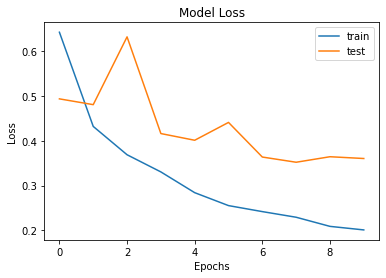

In [55]:
plt.plot(History3.history['loss'])
plt.plot(History3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

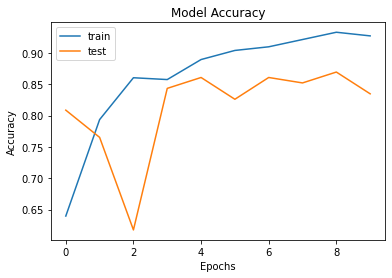

In [56]:
plt.plot(History3.history['accuracy'])
plt.plot(History3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [57]:
pred3=model3.predict(x_test)
pred_digits3= np.round(abs(pred3)).astype(int)
print(pred_digits3)

[[1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [58]:
model3.save("pikle files/BCDinceptionV3.h5")

In [59]:
_, acc3 = model3.evaluate(x_test, y_test)
print("Accuracy = ", (acc3 * 100.0), "%")

4/4 [==============================] - 6s 1s/step - loss: 0.3605 - accuracy: 0.8348
Accuracy =  83.4782600402832 %


In [60]:
print(classification_report(y_test,pred_digits3))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85        67
           1       0.75      0.90      0.82        48

    accuracy                           0.83       115
   macro avg       0.83      0.84      0.83       115
weighted avg       0.85      0.83      0.84       115



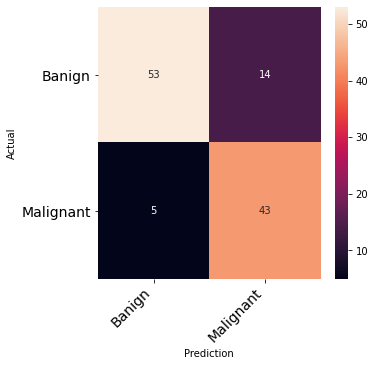

In [61]:
cm = confusion_matrix(y_test,pred_digits3)
print_confusion_matrix(cm,["Banign","Malignant"])

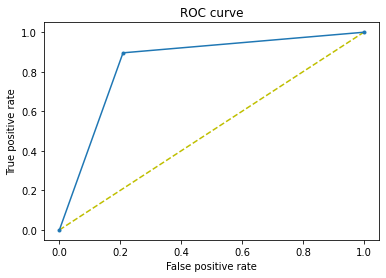

In [62]:
roc3 = pred_digits3.ravel()

fpr, tpr, thresholds = roc_curve(y_test, roc3)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [63]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  1    1
Name: thresholds, dtype: int32


In [64]:
auc_value3 = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value3)

Area under curve, AUC =  0.8434390547263683


## representation 

In [65]:
i=0
prop_class3=[]
mis_class3=[]

for i in range(len(y_test)):
    if(y_test[i])==pred_digits3[i]:
        prop_class3.append(i)

i=0
for i in range(len(y_test)):
    if(not (y_test[i])==pred_digits3[i]):
        mis_class3.append(i)
        
print(len(prop_class3))
print(len(mis_class3))

96
19


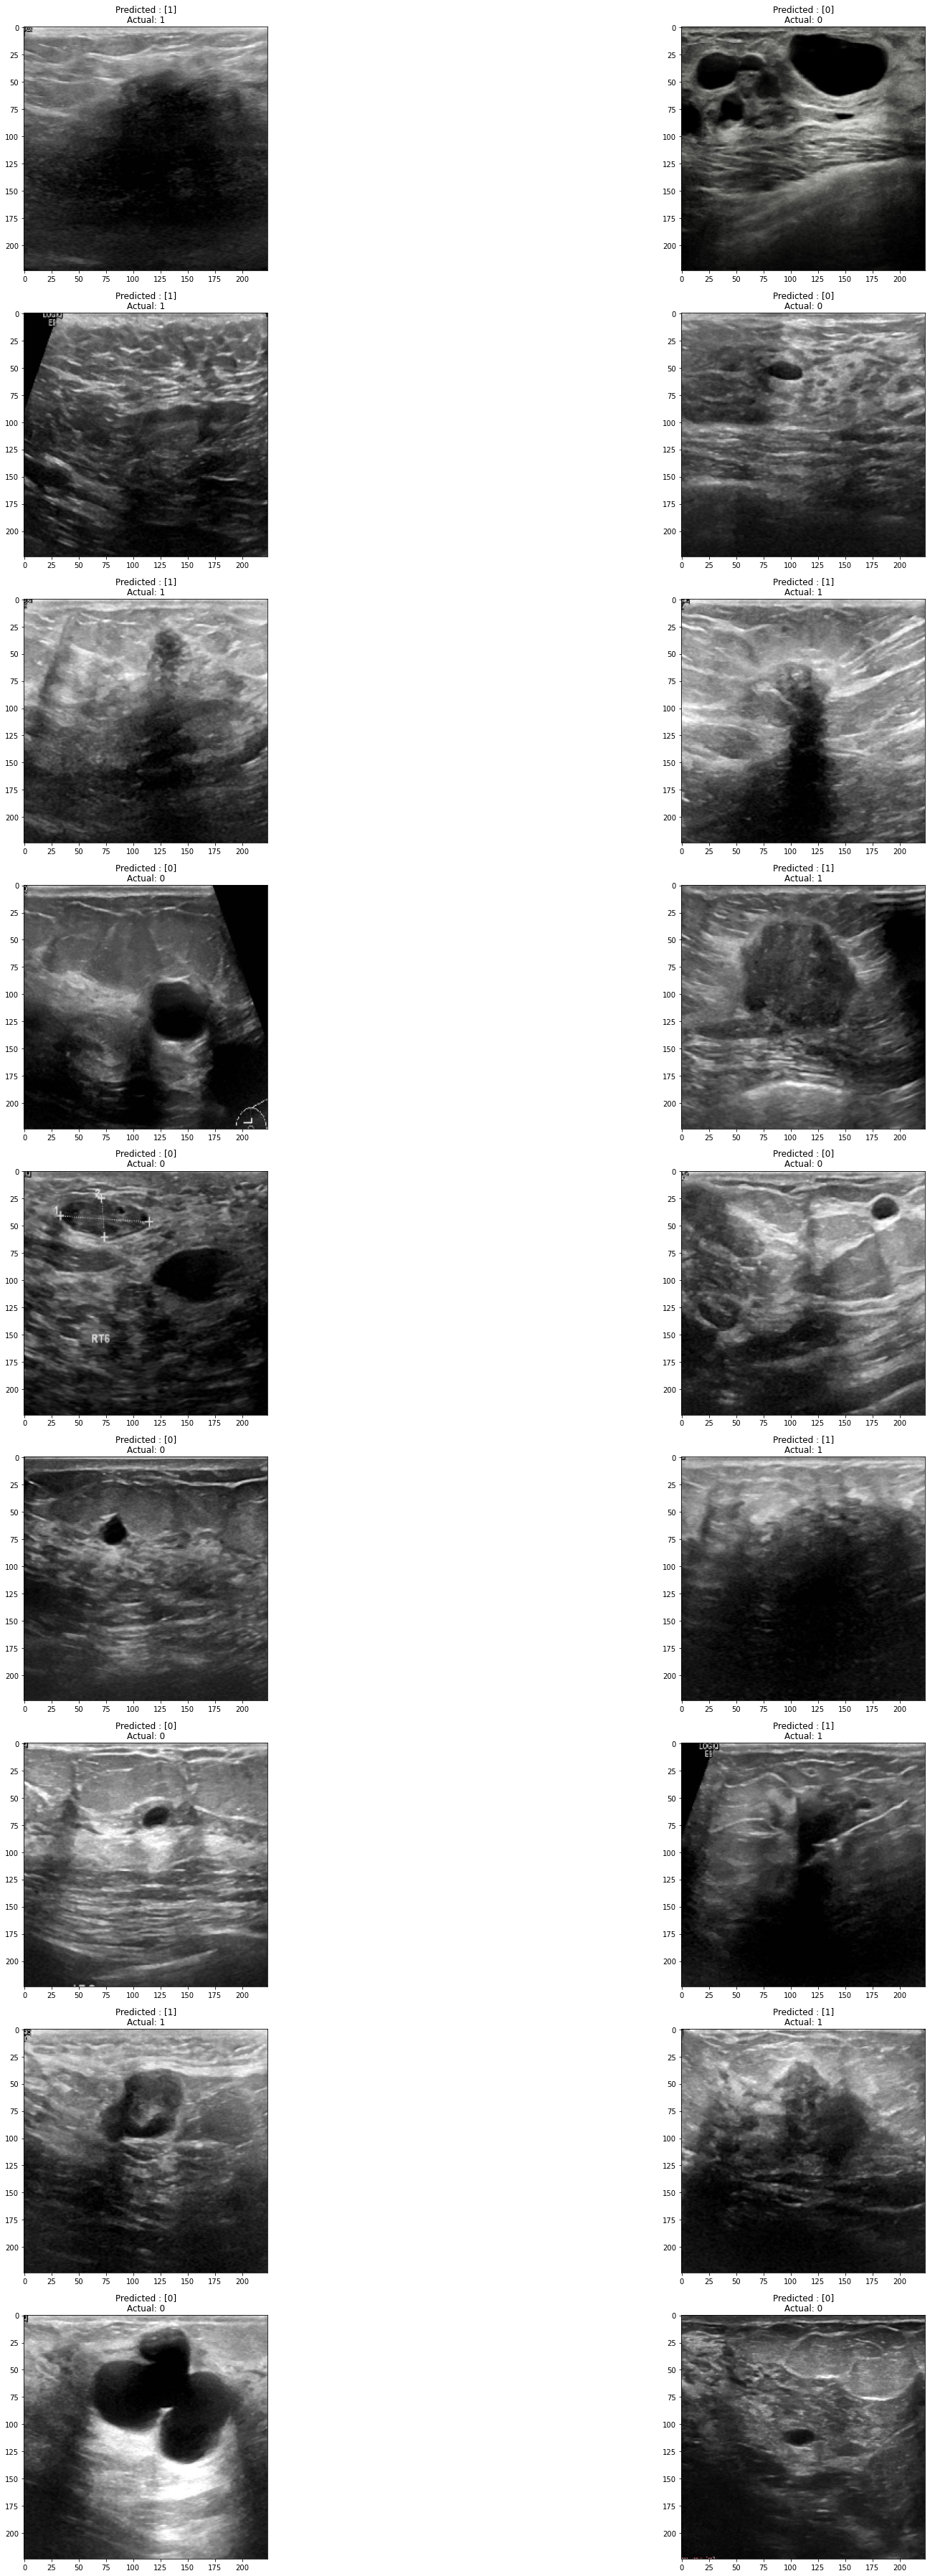

In [66]:
if len(prop_class3)>0:
    count=0
    fig,ax=plt.subplots(9,2)
    fig.set_size_inches(50,50)
    for i in range (9):
        for j in range (2):
            ax[i,j].imshow(x_test[prop_class3[count]])
            ax[i,j].set_title("Predicted : "+str(pred_digits3[prop_class3[count]])+"\n"+"Actual: "+ str(y_test[prop_class3[count]]))
            plt.tight_layout()
            count+=1
else:
    print("every images are miss-classify...")

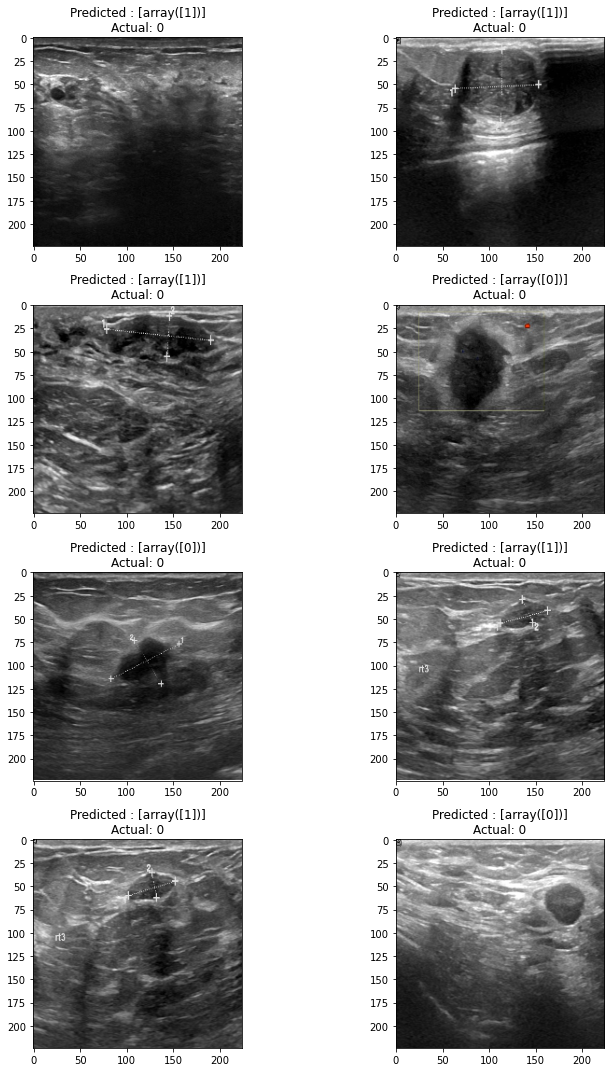

In [67]:
if len(mis_class3)>0:
    count=0
    fig,ax=plt.subplots(4,2)
    fig.set_size_inches(15,15)
    for i in range (4):
        for j in range (2):
            ax[i,j].imshow(x_test[mis_class3[count]])
            ax[i,j].set_title("Predicted : "+str([pred_digits3[mis_class3[count]]])+"\n"+"Actual: "+str(np.argmax([y_test[mis_class3[count]]])))
            plt.tight_layout()
            count+=1
else:
    print("every images are perfectly classify...")

## Compare Acuuracy

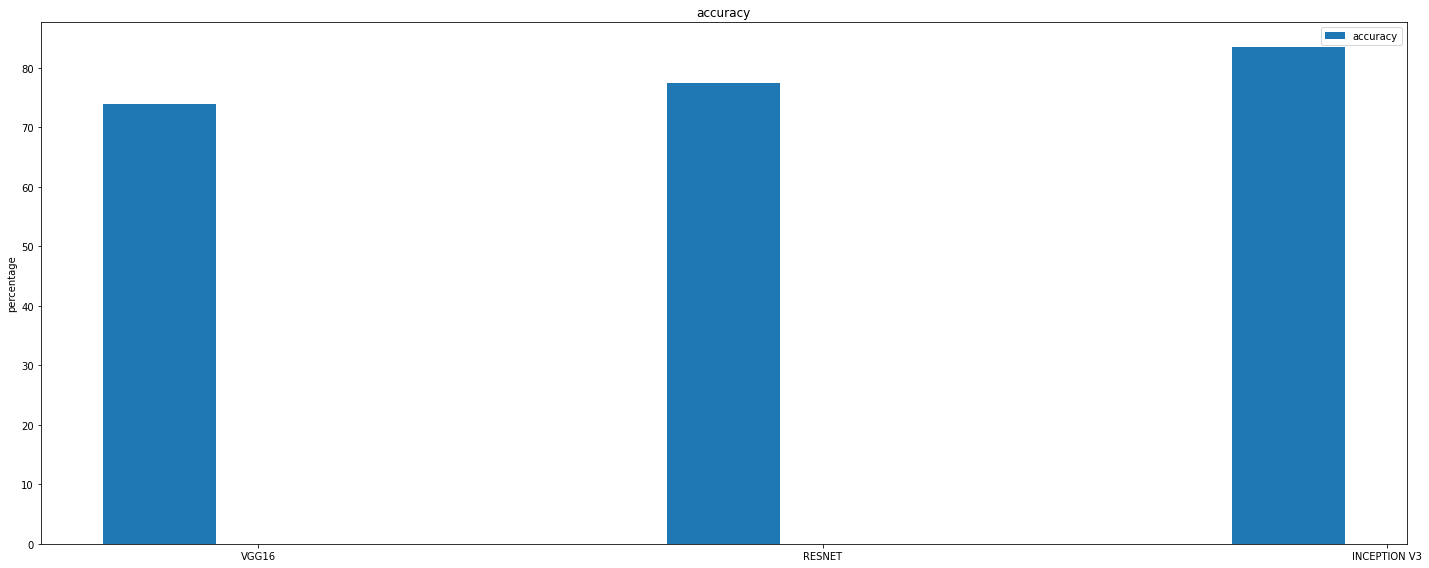

In [69]:
accuracy = [acc1*100,acc2*100,acc3*100]

labels = ["VGG16","RESNET","INCEPTION V3"]

x=np.arange(len(labels))
width= 0.35

fig , ax = plt.subplots(figsize=(20, 8))

rect1 = ax.bar(x - width/2 ,accuracy, label="accuracy", width=.2)

ax.set_ylabel('percentage')
ax.set_title('accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.tight_layout()

plt.legend()
plt.show()

In [ ]:
#====================================END==========================================#